# Probabilistic Nested Designs with Sensitivity Indices, version 7

## Load packages.

In [1]:
require(abind)
require(data.table)
require(deSolve)
require(magrittr)
require(rTensor)

require(ggplot2)
require(GGally)


Loading required package: abind
Loading required package: data.table
Loading required package: deSolve
Loading required package: magrittr
Loading required package: rTensor
Loading required package: ggplot2
Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


## Function to generate simulations.

In [2]:
# Create a multivariate function with specified properties:
#   tmax: maximum time
#   multiplicities: number of correlations each parameter has
#   degrees: polynomial degree of each parameter
#   dimension: the dimension of the output
#   returns a multivariate function of the vector of parameters and time
makeGenerator <- function(multiplicities, degrees, dimension) {

    single <- function(degree) {
      x0 <- runif(1)
      z0 <- runif(1)
      function(x) {
          if (x < x0)
              0
          else
              z0 * (x - x0)^degree
      }
    }
  
    locations <- lapply(multiplicities, function(m) sample(1:dimension, m))
    functions <- lapply(degrees, single)
    
    start <- runif(dimension, -0.25, 0.75)
    coefs <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)    
    shift <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)
    
    function(x, ts) {
        z <- rep(0, dimension)
        for (i in 1:length(locations))
            for (j in locations[[i]])
                z[j] <- z[j] + functions[[i]](x[i])
        ode(start, ts, function(t, y, params) {list((coefs %*% y) * z * (1 - ((shift %*% y) * z)))})
    }
    
}


## Functions for nesting designs

In [3]:
ssa.digits <- 30

In [4]:
ssa.scale <- 2^ssa.digits

In [5]:
ssa.level <- function(i) {
    if (i == 0)
        return(ssa.digits)
    n <- 0
    while (bitwAnd(i, 1) == 0) {
        n <- n + 1
        i <- bitwShiftR(i, 1)
    }
    n
}

In [6]:
ssa.depth <- function(i) {
    ssa.digits - ssa.level(i)
}

In [7]:
ssa.corner <- function(i, offset=0){
    d <- ssa.level(i) - offset
    c(i - 2^d, i + 2^d)
}

In [8]:
ssa.corners <- function(i1, i2, i3, offset=0) {
    axis <- function(s1, s2, s3) {
        if (s1 == 0)
            4 * s1 + 2 * s2 + s3
        else
            4 * (1 - s1) + 2 * (1 - s2) + (1 - s3)
    }
    merge(merge(merge(
        data.table(
            d1 = 1,
            d2 = 2,
            d3 = 4
        ),
        data.table(d1=1, i1=ssa.corner(i1, offset=offset), s1=0:1), by="d1", allow.cartesian=TRUE),
        data.table(d2=2, i2=ssa.corner(i2, offset=offset), s2=0:1), by="d2", allow.cartesian=TRUE),
        data.table(d3=4, i3=ssa.corner(i3, offset=offset), s3=0:1), by="d3", allow.cartesian=TRUE
    )[,
    .(
        i1,
        i2,
        i3,
        axis=mapply(axis, s1, s2, s3)
    )]
}

In [9]:
ssa.candidates <- function(i1, i2, i3) {
    CJ(
        i1=c(i1, ssa.corner(i1)),
        i2=c(i2, ssa.corner(i2)),
        i3=c(i3, ssa.corner(i3))
    )[,
        .(
            i1,
            i2,
            i3,
            x1 = i1 / ssa.scale,
            x2 = i2 / ssa.scale,
            x3 = i3 / ssa.scale
        )
    ]
}

In [10]:
ssa.start <- function() {
    result <- CJ(
        i1=c(0, ssa.scale),
        i2=c(0, ssa.scale),
        i3=c(0, ssa.scale)
    )[,
        .(
            sequence = 1:8     ,
            generation = 0     ,
            i1                 ,
            i2                 ,
            i3                 ,
            x1 = i1 / ssa.scale,
            x2 = i2 / ssa.scale,
            x3 = i3 / ssa.scale,
            compute = TRUE     ,
            measure = FALSE    ,
            probed  = TRUE     ,
            s1 = 0             ,
            s2 = 0             ,
            s3 = 0             ,
            s  = 0
        )
    ]
    result <- rbind(
        result,
        data.table(
            sequence = 9      ,
            generation = NA   ,
            i1 = ssa.scale / 2,
            i2 = ssa.scale / 2,
            i3 = ssa.scale / 2,
            x1 = 0.5          ,
            x2 = 0.5          ,
            x3 = 0.5          ,
            compute = FALSE   ,
            measure = TRUE    ,
            probed  = FALSE   ,
            s1 = 0. / 0.      ,
            s2 = 0. / 0.      ,
            s3 = 0. / 0.      ,
            s  = 0. / 0.
        )
    )
    setkeyv(result, c("i1", "i2", "i3"))
}

In [11]:
ssa.compute <- function(f, ts, xs, ys) {
    needed <- xs[compute == TRUE]
    for (row in 1:nrow(needed)) {
        ys <- rbind(
            ys,
            data.table(f(as.numeric(needed[row, .(x1, x2, x3)]), ts))[,
                .(
                    sequence = needed[row, sequence],
                    t = time,
                    y1 = `1`,
                    y2 = `2`,
                    y3 = `3`
                )
            ]
        )
    }
    xs[compute == TRUE, compute := FALSE]
    ys
}

In [12]:
ssa.measure <- function(xs, ys, focus=2) {
    
    result <- merge(
        merge(
            xs[measure == TRUE][, ssa.corners(i1, i2, i3), by=.(center=sequence)],
            xs,
            by=c("i1", "i2", "i3"),
            allow.cartesian=TRUE
        )[, .(center, axis, sequence)],
        ys,
        by="sequence",
        allow.cartesian=TRUE
    )[,
        .(y1 = mean(y1), y2 = mean(y2), y3 = mean(y3)), by=.(sequence=center, axis, t)
    ][,
        .(s1 = sd(y1), s2 = sd(y2), s3 = sd(y3)), by=.(sequence, t)
    ][,
        .(s1 = max(s1), s2 = max(s2), s3 = max(s3)), by=sequence
    ]

    xs[
        sequence %in% result$sequence,
        `:=`(
            s1=result$s1,
            s2=result$s2,
            s3=result$s3,
            generation=xs[, 1 + max(generation, na.rm=TRUE)]
        )
    ]
    
    y1min = min(ys$y1)
    y1max = max(ys$y1)
    y2min = min(ys$y2)
    y2max = max(ys$y2)
    y3min = min(ys$y3)
    y3max = max(ys$y3)

    normalize <- function (i, s1, s2, s3)
        max(s1 / (y1max - y1min), s2 / (y2max - y2min), s3 / (y3max - y3min)) * focus^ssa.depth(i)
    xs[, `:=`(measure = FALSE, s = mapply(normalize, i1, s1, s2, s3))]
    
    result
}

In [13]:
ssa.probe <- function(xs, alpha=1, maxdepth=-log(sqrt(.Machine$double.eps),2)) {
    choices <- xs[probed == FALSE & !is.na(s), .(sequence, s)]
    if (nrow(choices) == 1)
        choice <- choices$sequence
    else
        choice <- sample(choices$sequence, 1, prob = choices$s^alpha)
    probe <- xs[sequence == choice, .(sequence, i1, i2, i3)]
    xs[
        probed == FALSE & mapply(ssa.depth, i1) < maxdepth,
        .(sequence, i1, i2, i3, rank=frank(-s, ties.method="random"))
    ][
        rank == 1,
        .(sequence, i1, i2, i3)
    ]
    candidates <- ssa.candidates(probe$i1, probe$i2, probe$i3)
    setkeyv(candidates, c("i1", "i2", "i3"))
    candidates <- candidates[!xs]
    n <- xs[, max(sequence)]
    if (nrow(candidates) > 0) {
        candidates <- candidates[, .(
            sequence = n + (1:nrow(candidates)),
            generation = NA,
            i1, i2, i3,
            x1, x2, x3,
            compute = TRUE ,
            measure = FALSE,
            probed  = FALSE,
            s1 = 0. / 0.,
            s2 = 0. / 0.,
            s3 = 0. / 0.,
            s  = 0. / 0.
        )]
        n <- candidates[, max(sequence)]
    }
    probes <- ssa.corners(probe$i1, probe$i2, probe$i3, offset=1)
    probes <- probes[, .(
        sequence = n + (1:nrow(probes)),
        generation = NA,
        i1, i2, i3,
        x1 = i1 / ssa.scale,
        x2 = i2 / ssa.scale,
        x3 = i3 / ssa.scale,
        compute = FALSE,
        measure = TRUE ,
        probed  = FALSE,
        s1 = 0. / 0.,
        s2 = 0. / 0.,
        s3 = 0. / 0.,
        s  = 0. / 0.
    )]
    if (nrow(candidates) > 0)
        result <- rbind(
            xs,
            candidates,
            probes
        )
    else
        result <- rbind(
            xs,
            probes
        )
    result[sequence == probe$sequence, `:=`(compute=TRUE, measure=FALSE, probed=TRUE)]
    setkeyv(result, c("i1", "i2", "i3"))
    list(
        sequence=probe$sequence,
        xs=result
    )
}

## Reproducible random numbers.

In [14]:
RNGkind("Mersenne-Twister", "Inversion", "Rejection")

In [15]:
set.seed(46)

## Create a simulation function.

In [16]:
f <- makeGenerator(c(2, 2, 3), c(0, 1, 2), 3)

## Example application

### Set time resolution.

In [17]:
ts <- (0:20) / 2

### Initialize experiment at bounds of domain.

In [18]:
xs <- ssa.start()

In [19]:
xs

sequence,generation,i1,i2,i3,x1,x2,x3,compute,measure,probed,s1,s2,s3,s
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0.0,0.0,0.0,TRUE,FALSE,TRUE,0,0,0,0
2,0,0,0,1073741824,0.0,0.0,1.0,TRUE,FALSE,TRUE,0,0,0,0
3,0,0,1073741824,0,0.0,1.0,0.0,TRUE,FALSE,TRUE,0,0,0,0
4,0,0,1073741824,1073741824,0.0,1.0,1.0,TRUE,FALSE,TRUE,0,0,0,0
9,NA,536870912,536870912,536870912,0.5,0.5,0.5,FALSE,TRUE,FALSE,NaN,NaN,NaN,NaN
5,0,1073741824,0,0,1.0,0.0,0.0,TRUE,FALSE,TRUE,0,0,0,0
6,0,1073741824,0,1073741824,1.0,0.0,1.0,TRUE,FALSE,TRUE,0,0,0,0
7,0,1073741824,1073741824,0,1.0,1.0,0.0,TRUE,FALSE,TRUE,0,0,0,0
8,0,1073741824,1073741824,1073741824,1.0,1.0,1.0,TRUE,FALSE,TRUE,0,0,0,0


### Iterate several times.

There are two adjustable parameters: `focus` and `alpha`. The `focus` parameter controls the emphasis on depth, with `focus = 0` ignoring depth and `focus = 2` being neutral with respect to depth. The `alpha` parameter controls how peaked the probability of selecting an area to probe is on the nonlinearity there, with `alpha = 0` for no sensitivity to nonlinearity and `alpha = 1` for probability of selection proportional to the amount of nonlinearity.

In [21]:
ys <- NULL
for (k in 1:2500) {
    # Perform pending computations.
    ys <- rbind(ys, ssa.compute(f, ts, xs, NULL))
    # Measure divergences.
    ssa.measure(xs, ys, focus = 0.25)
    # Select where to probe further.
    result <- ssa.probe(xs, alpha = 1)
    # Update grid.
    xs <- result$xs
}
ys <- rbind(ys, ssa.compute(f, ts, xs, NULL))

### Save results.

In [22]:
write.table(xs, file="xs-v7.csv", row.names=FALSE, sep=",")
xs %>% dim

[1] 54744    15

In [23]:
write.table(ys, file="ys-v7.csv", row.names=FALSE, sep=",")
ys %>% dim

[1] 782103      5

In [ ]:
xs <- fread("xs-v7.csv")
setkeyv(xs, c("i1", "i2", "i3"))

ys <- fread("ys-v7.csv")
setkeyv(ys, c("sequence", "t"))

### Plot sampling pattern.

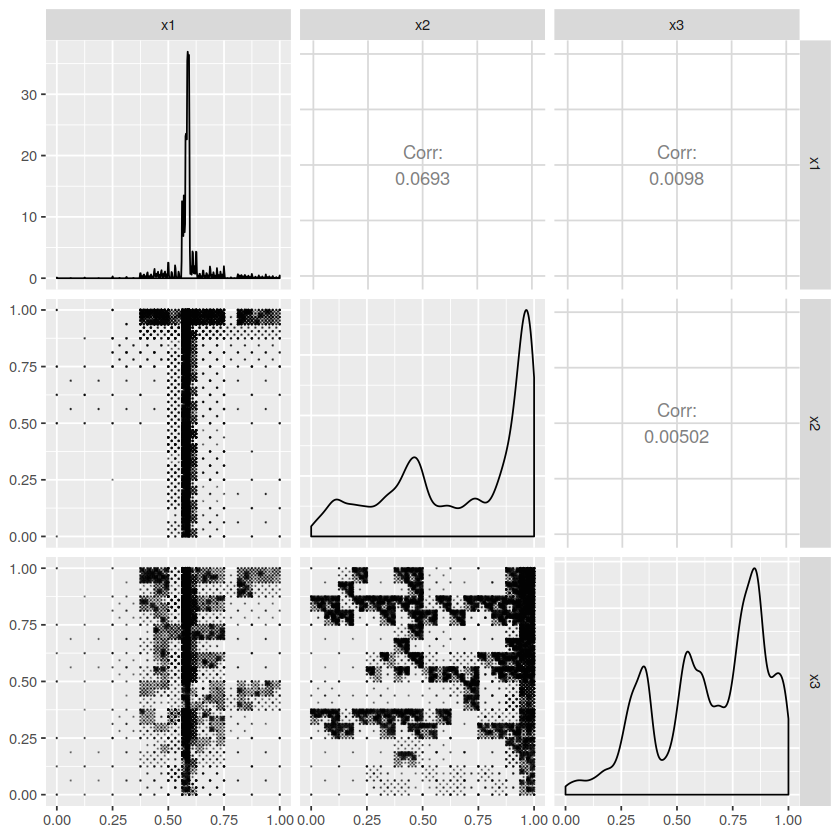

In [24]:
ggpairs(
    xs,
    6:8,
#   mapping = aes(color=factor(mapply(ssa.depth, i1))),
    lower = list(continuous = wrap("points", alpha = 0.2, size=0.05))
)

### Compute sensitivity indices.

#### Organize the data for sensitivity analysis, just using the final timestep.

In [40]:
xys.wide <- merge(
    xs[probed == TRUE, .(sequence, x1, x2, x3)],
    ys[t == 10, .(sequence, y1, y2, y3)]
)
xys.wide %>% head

sequence,x1,x2,x3,y1,y2,y3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,-0.1900320,0.5144967,0.4093612
2,0,0,1,5.0782072,1.9488670,2.2320137
3,0,1,0,-0.1437119,0.5511418,0.4093612
4,0,1,1,4.9929679,1.9513684,2.2540234
5,1,0,0,-0.1900320,8.2070979,-1.8065843
6,1,0,1,5.2555080,1.3837551,1.9296318


#### Function for computing first-order sensitivity index.

##### Saltelli's method.

This sometimes yields values above one or below zero, but the bootstrapping seems to work better.

In [41]:
sensitivity_indices <- function(xy) {
    # Convert to long format.
    xy.tall <- melt(
        melt(
            xy,
            id.vars=c("sequence", "y1", "y2", "y3"),
            measure.vars=c("x1", "x2", "x3"),
            variable.name="i",
            value.name="x"
        ),
        id.vars=c("sequence", "i", "x"),
        measure.vars=c("y1", "y2", "y3"),
        variable.name="j",
        value.name="y"
    )
    # Compute `E[y_j]`.
    ybar.all <- xy.tall[, .(ybar.all=mean(y)), by=.(i, j)]
    # Computer `Var[y_j]`.
    var.all <- merge(ybar.all, xy.tall)[, .(var.all=mean((y - ybar.all)^2)), by=.(i, j)]
    # Compute `E[y_j | x_i = x]`.
    ybar.x <- xy.tall[, .(ybar.x=mean(y)), by=.(i, j, x)]
    # Compute `Var[ E[y_j | x_i = x] ]`.
    var.x <- merge(ybar.all, ybar.x)[, .(var.x=mean((ybar.x - ybar.all)^2)), by=.(i, j)]
    # Compute the first-order sensitivity `Var[E[y_j|x_i=x]] / Var[y]`.
    s.x <- merge(var.all, var.x)[, .(i, j, s.x=var.x/var.all)]
    # Return the result.
    s.x
}

##### Literal method.

This yields values between zero and one, but the bootstrapping doesn't seem to work well.

In [42]:
sensitivity_indices <- function(xy) {
    # Convert to long format.
    xy.tall <- melt(
        melt(
            xy,
            id.vars=c("sequence", "y1", "y2", "y3"),
            measure.vars=c("x1", "x2", "x3"),
            variable.name="i",
            value.name="x"
        ),
        id.vars=c("sequence", "i", "x"),
        measure.vars=c("y1", "y2", "y3"),
        variable.name="j",
        value.name="y"
    )
    # Computer `Var[y_j]`.
    var.all <- xy.tall[, .(var.all=var(y)), by=.(i, j)]
    # Compute `E[y_j | x_i = x]`.
    ybar.x <- xy.tall[, .(ybar.x=mean(y)), by=.(i, j, x)]
    # Compute `Var[ E[y_j | x_i = x] ]`.
    var.x <- ybar.x[, .(var.x=var(ybar.x)), by=.(i, j)]
    # Compute the first-order sensitivity `Var[E[y_j|x_i=x]] / Var[y]`.
    s.x <- merge(var.all, var.x)[, .(i, j, s.x=var.x/var.all)]
    # Return the result.
    s.x
}

#### Function to resample sensitivity indices.

This is a very simple bootstrap, just resampling with replacement. It looks like it is biased.

In [43]:
sensitivity_indices_resample <- function(xy, n) {
    rows <- nrow(xy)
    result <- cbind(n=0, sensitivity_indices(xy))
    for (i in 1:n) {
        xy.sample <- xy[sample(1:rows, rows, replace=TRUE)]
        xy.sample[, sequence:=1:rows]
        result <- rbind(
            result,
            cbind(n=i, sensitivity_indices(xy.sample))
        )
    }
    result
}

#### Compute the indices.

In [44]:
s.x <- sensitivity_indices_resample(xys.wide, 1000)
s.x[n == 0]

n,i,j,s.x
<dbl>,<fct>,<fct>,<dbl>
0,x1,y1,0.4521335
0,x1,y2,0.8641704
0,x1,y3,0.6232122
0,x2,y1,0.3204271
0,x2,y2,0.2479287
0,x2,y3,0.2092908
0,x3,y1,0.9118776
0,x3,y2,0.5387907
0,x3,y3,0.7453109


#### Plot the indices.

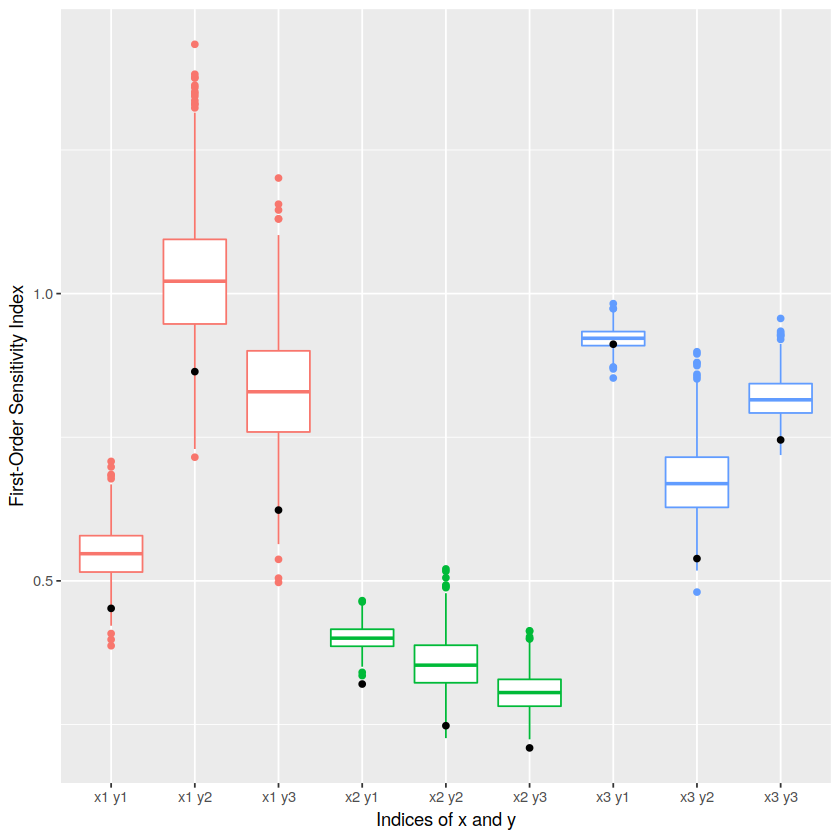

In [45]:
ggplot(s.x[n != 0], aes(x=paste(i, j), y=s.x, color=i)) +
    geom_boxplot() +
    xlab("Indices of x and y") +
    ylab("First-Order Sensitivity Index") +
    guides(color=FALSE) +
    geom_point(data=s.x[n == 0], aes(x=paste(i, j), y=s.x), color="black")

The first-order sensitivity index is `s_ij = Var[ E[y_j | x_i ] ] / Var[ y_j ]`.

The solid black dots show the unbootstrapped estimates. **It is suspicious that the bootstrapped estimates are almost always higher by more than one quartile.**

It looks like `y2` and `y3` have strong dependence on `x1`, and `y1` and `y3` have strong dependence on `x3`. The results do not seem dependenceof `x2`. The dependence of `y1` on `x1` and of `y2` on `x3` is moderate.

### Experiment with partitioning data into two contiguous sets and then computing sensitivity indices.

Even though there are the global sensitivities listed above, there might be regions of `(x1, x2, x3)` where some of those sensitivities disappear or others appear. To investigate this, let's try partitioning `(x1, x2, x3)` by hyperplanes of constant `x1`, `x2`, or `x3` and then computing the sensitivity indices on either side of partition. (This is somewhat like Monte-Carlo filtering.)

This is an attempt to find boundaries in the phase diagram of `(x1, x2, x3`).

#### Separate by x values into a left and right partition.

In [46]:
us <- xs[,
    .(u=round((1:6)/7, 3)),
    by=.(sequence)
][,
    .(k=c("split on x1", "split on x2", "split on x3")),
    by=.(sequence, u)
]

In [47]:
uxys.wide <- merge(us, xys.wide, by="sequence", allow.cartesian=TRUE)
uxys.wide <- rbind(
    uxys.wide[k == "split on x1" & x1 <  u, .(k, u, s='below split', sequence, x1, x2, x3, y1, y2, y3)],
    uxys.wide[k == "split on x1" & x1 >= u, .(k, u, s='above split', sequence, x1, x2, x3, y1, y2, y3)],
    uxys.wide[k == "split on x2" & x2 <  u, .(k, u, s='below split', sequence, x1, x2, x3, y1, y2, y3)],
    uxys.wide[k == "split on x2" & x2 >= u, .(k, u, s='above split', sequence, x1, x2, x3, y1, y2, y3)],
    uxys.wide[k == "split on x3" & x3 <  u, .(k, u, s='below split', sequence, x1, x2, x3, y1, y2, y3)],
    uxys.wide[k == "split on x3" & x3 >= u, .(k, u, s='above split', sequence, x1, x2, x3, y1, y2, y3)]
)
uxys.wide %>% dim

[1] 45144    10

In [48]:
us <- us[, .(s=c("below split", "above split")), by=.(k, u)]
us.x <- NULL
for (row in 1:nrow(us))
    us.x <- rbind(
        us.x,
        cbind(
            us[row, .(k, u, s)],
            sensitivity_indices_resample(merge(us[row], uxys.wide, by=c("k", "u", "s")), 1000)
        )
    )
us.x %>% dim

[1] 324324      7

Warning message:
“Removed 280 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 6 rows containing non-finite values (stat_boxplot).”

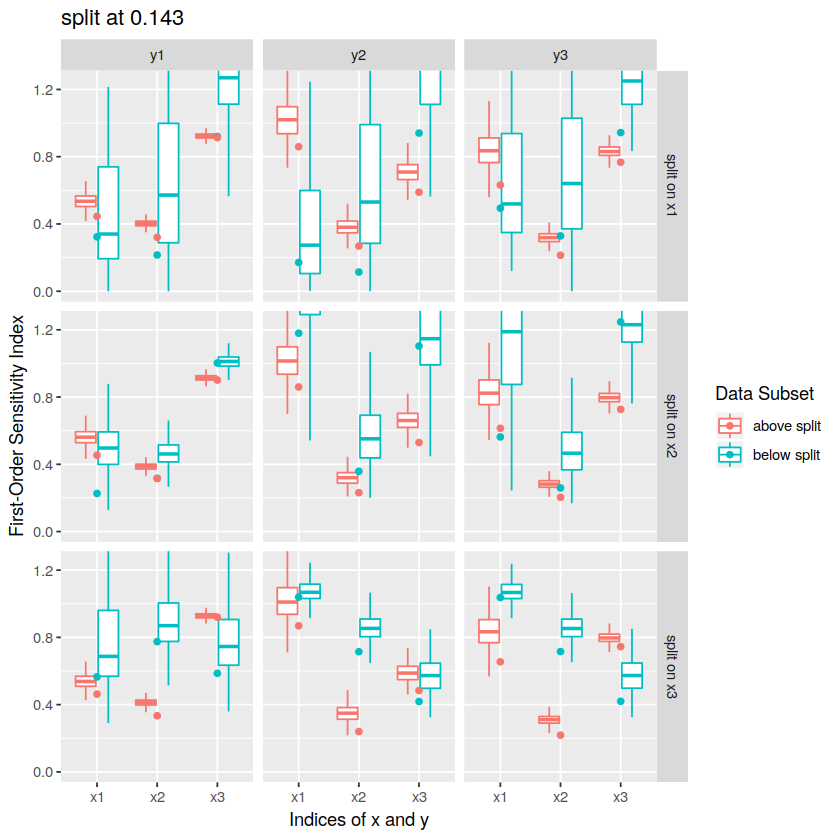

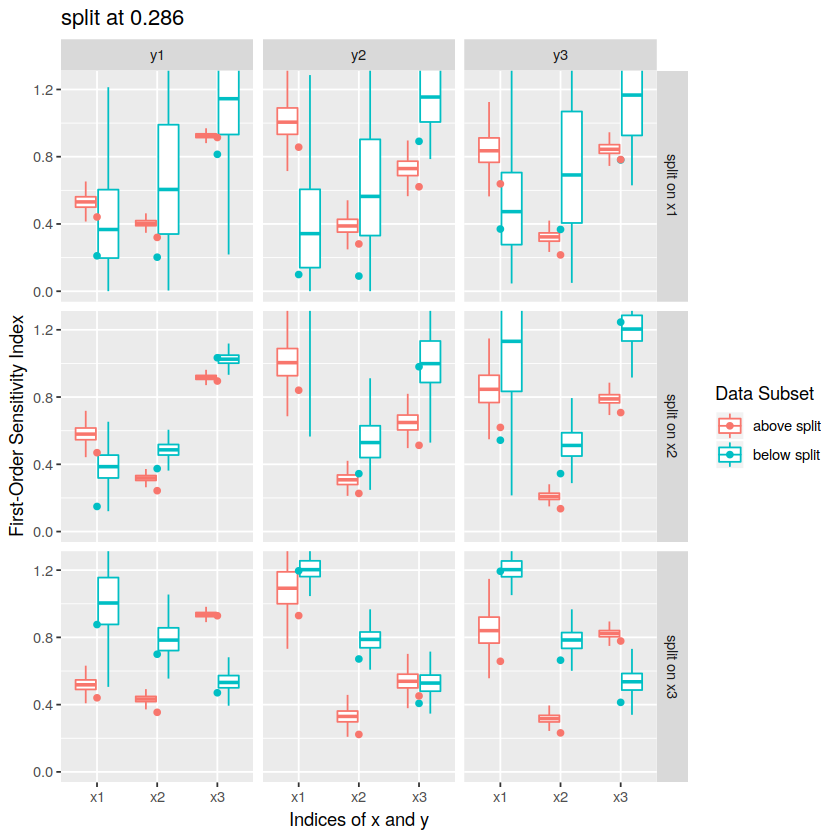

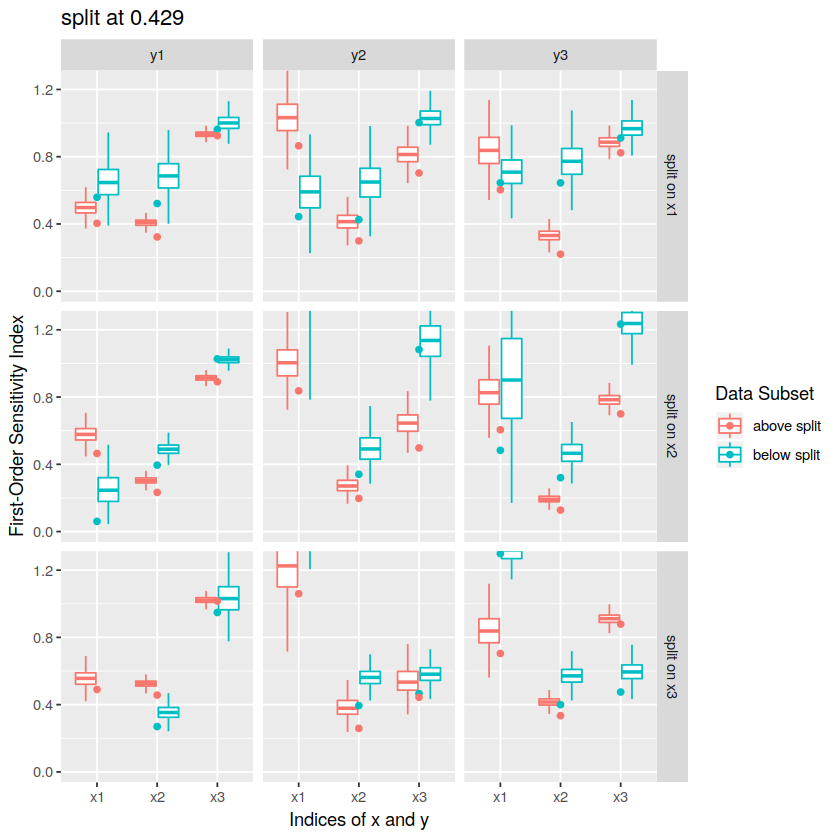

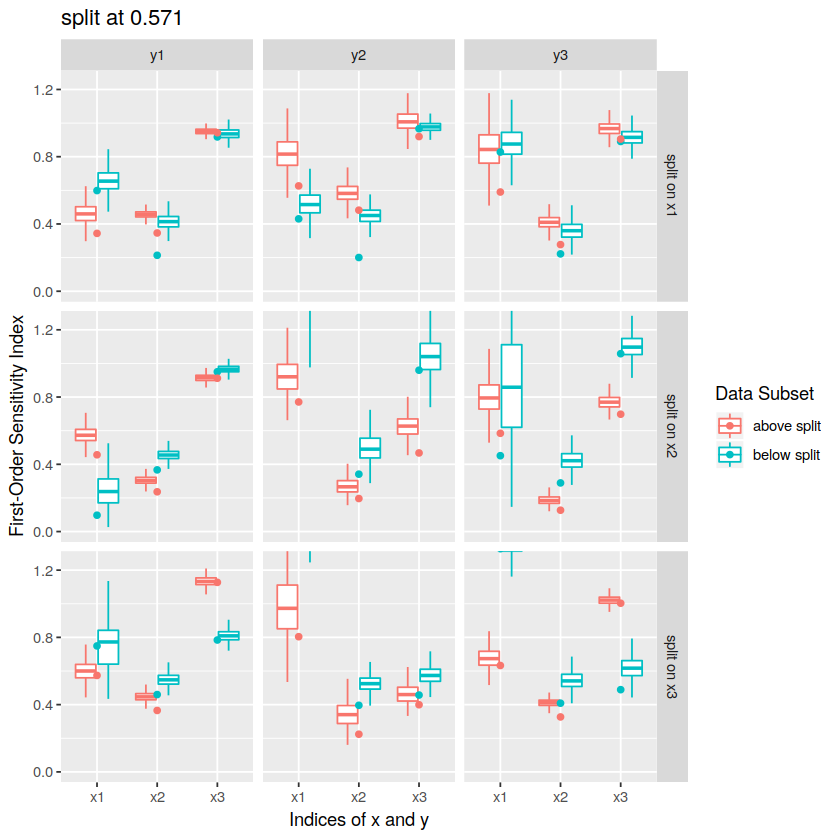

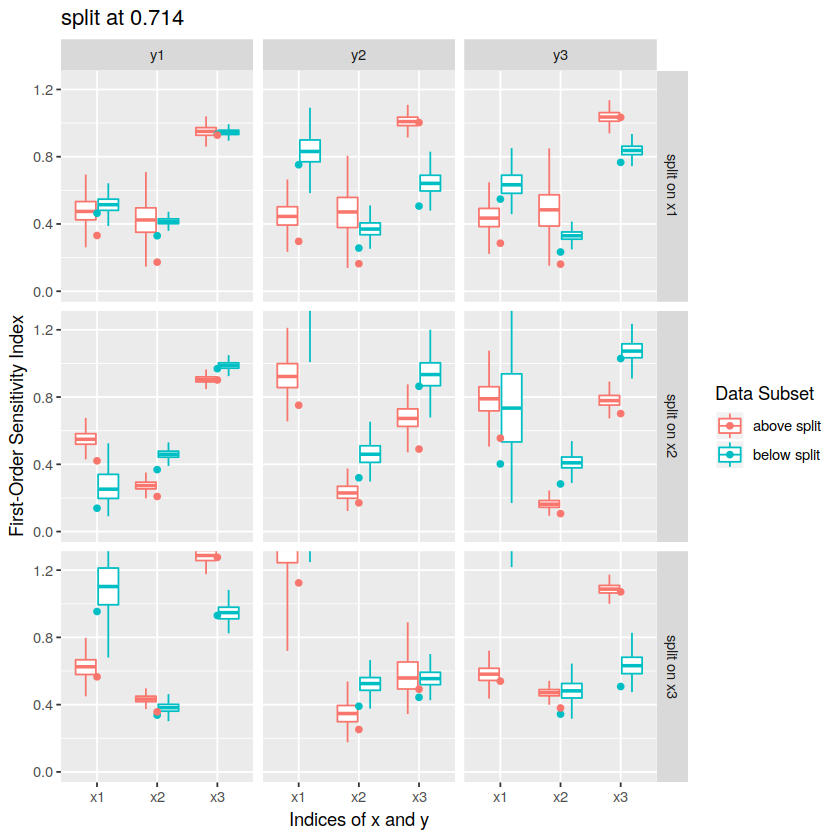

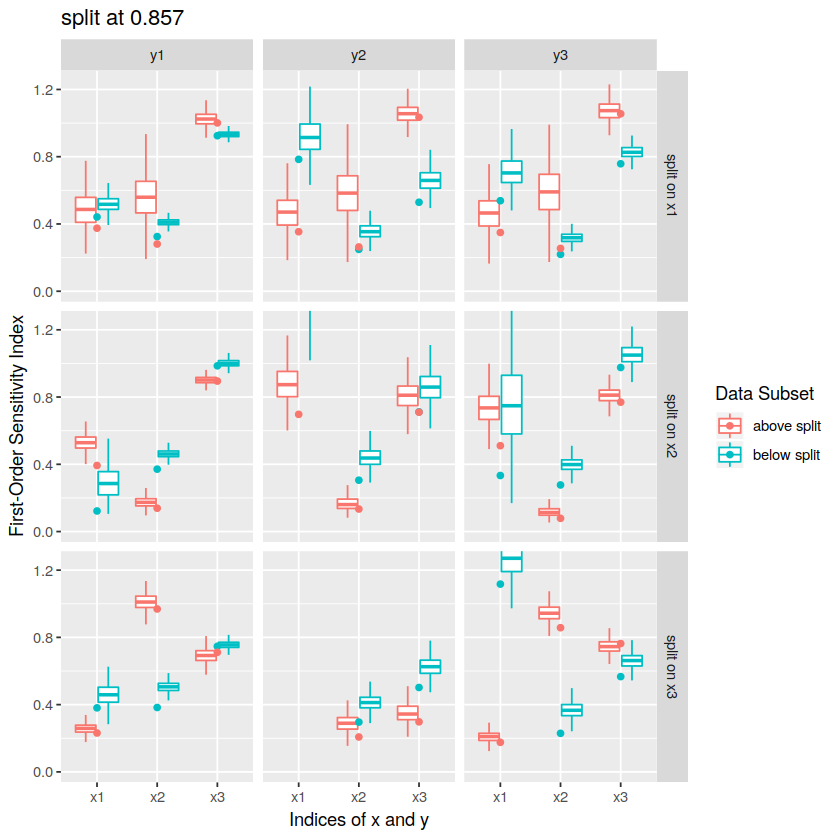

In [53]:
for (u1 in unique(us$u)) {
    g <- ggplot(us.x[u1 == u & n != 0], aes(x=i, y=s.x, color=s)) +
        geom_boxplot(outlier.shape=NA) +
        coord_cartesian(ylim = c(0, 1.25))  +
        xlab("Indices of x and y") +
        ylab("First-Order Sensitivity Index") +
        guides(color=guide_legend(title="Data Subset")) +
        geom_point(data=us.x[u1 == u & n == 0], aes(x=i, y=s.x, color=s)) +
        facet_grid(k ~ j) +
        ggtitle(paste("split at", u1))
    print(g)
}

The solid dots show the unbootstrapped estimates.

Splitting `x1`, `x2`, or `x3` at `1/7` doesn't yield significant differences in the sensitivity indices on either side of the split. By the time the split reaches beyond `2/7`, significant differences appear. For example, that of `y3` on `x1` when split into the insignificant`x3 > 6/7` vs the significant`x3 < 6/7`.